In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

In [2]:
# random seed for reproducibility
np.random.seed(12345)

### Data

In [3]:
dname="DATA"; fname=dname+'/x_RBM_2024_exercise.dat'


# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=10 digits
[0 0 1 1 0 0 0 0 1 1]
[0 0 0 1 0 0 0 1 0 0]
[1 0 0 0 1 0 1 0 0 0]
[0 1 1 1 0 1 0 1 0 0]
[1 1 1 0 1 1 1 1 0 0]
[0 1 0 0 1 1 1 0 0 0]
[1 0 1 0 0 0 1 1 1 1]
[1 0 1 1 0 1 1 0 0 0]
[1 0 1 0 0 0 0 1 1 1]
[1 1 0 0 1 1 0 0 0 0]
[0 1 0 1 0 0 0 0 1 1]
[1 1 0 1 1 1 1 1 0 0]
...


In [4]:
from IPython.display import display_html 
import pandas as pd

def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: white;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v[:N1])
df0s = df0.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)

display_html(df0s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,1,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,1,0,1,0,0
4,1,1,1,0,1,1,1,1,0,0
5,0,1,0,0,1,1,1,0,0,0
6,1,0,1,0,0,0,1,1,1,1
7,1,0,1,1,0,1,1,0,0,0
8,1,0,1,0,0,0,0,1,1,1
9,1,1,0,0,1,1,0,0,0,0


## Initialize

In [5]:
# RBM, nr of hidden units
M = 3
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a= [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b= [0. 0. 0.]


## Plotting

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


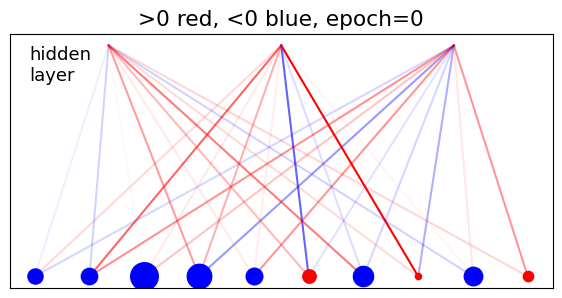

In [6]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(w, a, b, epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
                  
plotgraph(w,a,b)

### Activation function with sigmoid


In [7]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 0
activate(v[k],w,b,GAP,info=True)

input= [0 0 1 1 0 0 0 0 1 1]
act= [0.71335964 0.78434445 0.62083422]
prob= [0.67114309 0.68661569 0.65040826]
output= [1 1 0]


array([1, 1, 0])

## RBM train


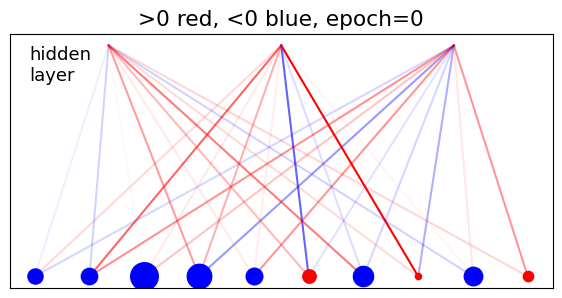

=================k==================================
----------- epoch = 0   k= 499   m= 500
dw = [[ 0.066  0.064  0.052]
 [-0.122 -0.144 -0.062]
 [ 0.146  0.134  0.078]
 [ 0.064  0.064  0.084]
 [-0.042 -0.06  -0.024]
 [ 0.074  0.08   0.014]
 [ 0.    -0.04   0.   ]
 [-0.182 -0.25  -0.222]
 [ 0.092  0.124  0.116]
 [-0.184 -0.222 -0.142]]
da = [ 0.116 -0.128  0.212  0.124 -0.034  0.134  0.026 -0.254  0.18  -0.234]
db = [-0.034 -0.066 -0.03 ]
----------- epoch = 1   k= 499   m= 500
dw = [[ 0.03564356  0.03762376  0.05148515]
 [ 0.02970297  0.03960396  0.04950495]
 [ 0.03762376  0.03168317  0.0039604 ]
 [-0.04950495 -0.03960396  0.02970297]
 [-0.06336634 -0.08118812  0.00990099]
 [ 0.04356436  0.05544554  0.00990099]
 [ 0.00594059 -0.01584158 -0.00792079]
 [-0.01782178 -0.03168317 -0.03168317]
 [-0.01980198  0.00792079  0.06930693]
 [-0.04752475 -0.01980198 -0.0039604 ]]
da = [ 0.06534653  0.06534653  0.04158416 -0.06138614 -0.09306931  0.04752475
 -0.01980198 -0.02574257  0.         -0.05

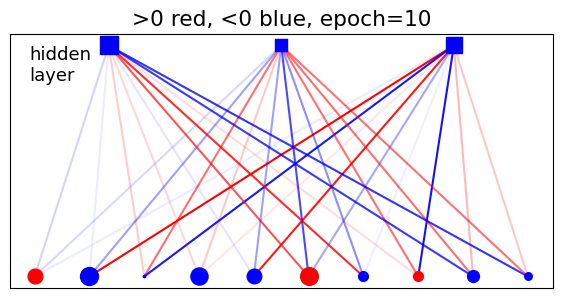

l_rate =  0.9090909090909092


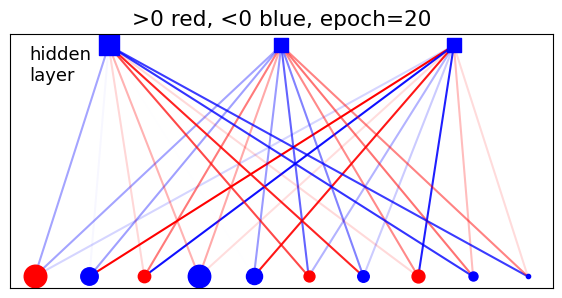

l_rate =  0.8333333333333337


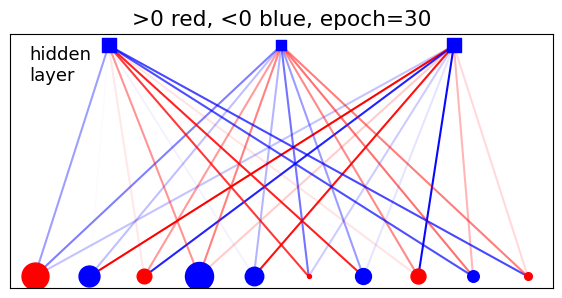

l_rate =  0.7692307692307697


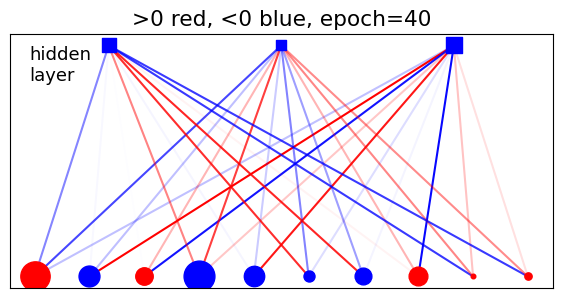

l_rate =  0.7142857142857149


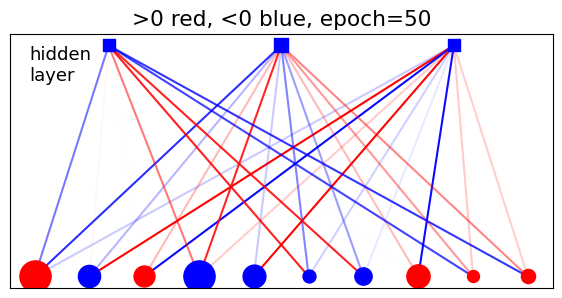

l_rate =  0.6666666666666671


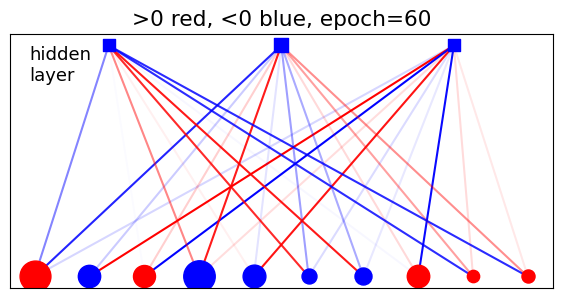

l_rate =  0.6250000000000006


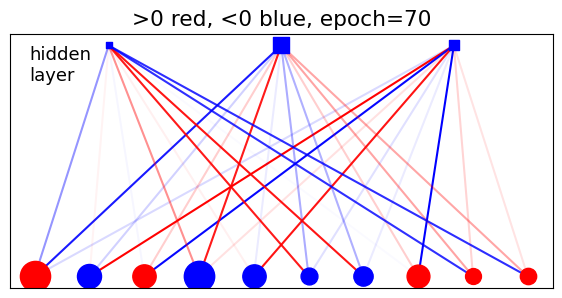

l_rate =  0.5882352941176475


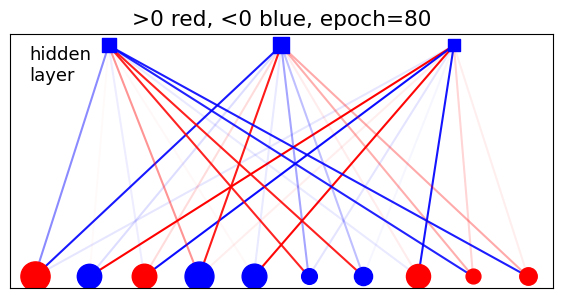

l_rate =  0.555555555555556


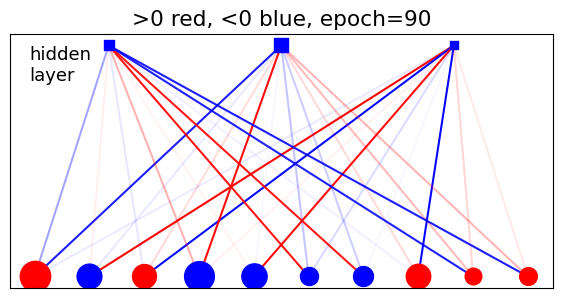

l_rate =  0.5263157894736847


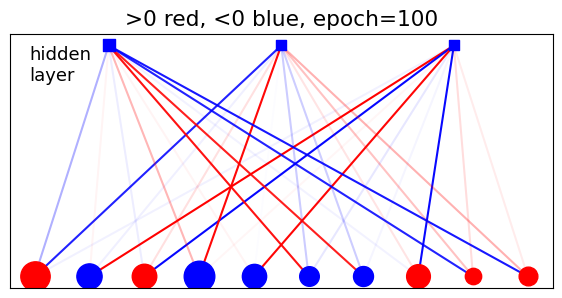

l_rate =  0.5000000000000009


In [8]:
plotgraph(w0, a0, b0)

#n_CD, the number of contrastive divergence steps.
n_CD=2

# learning rate
l_rate = 1.0

# minibatch
mini, m = 500, 0

# train model
print('=================k==================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate in l_rate_m
    l_rate_m = l_rate / mini
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h 
        h = activate(v[k],w,b,GAP)
        hf=h
        for counter in range(n_CD):
            # negative CD phase: generating fantasy vf
            vf = activate(hf,w.T,a,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,w,b,GAP)

        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model+= np.outer(vf.T,hf)
    
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)
            db = l_rate_m*(h_data - h_model)
            if epoch<=1 and k<=mini:
                print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                print('dw =',dw)
                print('da =',da)
                print('db =',db)
            # basic step of vanilla gradient descent, from eq.(211)
            w = w + dw
            a = a + da
            b = b + db
            m=0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(w,a,b,epoch+1)
        print('l_rate = ',l_rate)

Below we define the functions necessary to calculate the energy of a RBM, the partition function of the system and the log-likelihood of a particul RBM state w.r.t. to the dataset.

In [9]:
import itertools
def energy(v, h, a, b, w):
    return -(np.dot(v,a) + np.dot(h,b) + np.dot(v, np.dot(w,h)))

def partition(w, a, b, SPINS):
    L,M=a.shape[0], b.shape[0]
    if SPINS:
        state0, state1=-1, 1
    else: 
        state0, state1=0, 1
    #calculate partition function:
    #is the summation on all possible values of visible and hidden layer 
    Z=0
    for state in itertools.product(*([[state0, state1]]*(L+M))):
        v=state[:L]  
        h=state[L:] 
        Z += np.exp(-energy(v, h, a, b, w))     
    return Z

def loglike(v_t, w, a, b, SPINS):
    N_t=v_t.shape[0]
    E=0
    for k in range(N_t):
        h = activate(v_t[k], w, b, SPINS)
        #sum energy for every visible (and hidden) layer in dataset
        E += energy(v_t[k],h,a,b,w)
    #mean energy at the end of the epoch
    E /= N_t
    #evaluate the partition function with parameters from the training on the epoch
    Z = partition(w,a,b,SPINS)
    #evaluate log likelihood as - <E> - lnZ
    LL = - E - np.log(Z)
    return LL

We define a `RBM_trainer` function that takes as arguments the initial weights of the model and the hyperparameters of the training algorithm, trains the model, plots the intermediate states of the model at different epochs and calculates the log-likelihood between the model and the original data at different steps. These steps are labeled `t` in the following plots, and refer to different minibatch ordinal numbers. We decide for this small time step after verifying that the maximum likelihood already occurs at the first epoch.

In [10]:
#function the trains the RBM and plots the weights at successive epochs
def RBM_trainer(w0, a0, b0, n_CD=1, l_rate=1.0, mini=500, epochs=100, show_model=True, verbose=True, result_log=None):
    '''
    n_CD: the number of contrastive divergence steps.
    l_rate: learning rate
    mini: minibatch
    '''
    w,a,b=np.copy(w0),np.copy(a0),np.copy(b0)
    if show_model==True:
        plotgraph(w,a,b,0)
    m=0
    # train model
    print('=================k==================================')

    loglikes=[]
    for epoch in range(epochs):
        
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        for k in range(N):
            if m==0:
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L),np.zeros(L)
                h_data, h_model = np.zeros(M),np.zeros(M)
                vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
            # positive CD phase: generating h 
            h = activate(v[k],w,b,GAP)
            hf=h
            for counter in range(n_CD):
                # negative CD phase: generating fantasy vf
                vf = activate(hf,w.T,a,GAP)
                # one more positive CD phase: generating fantasy h from fantasy vf 
                hf = activate(vf,w,b,GAP)

            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            m += 1
            # minibatch
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if verbose==True and (epoch<=1 and k<=mini):
                    print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                    print('dw =',dw)
                    print('da =',da)
                    print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                w = w + dw
                a = a + da
                b = b + db
                m=0

                loglikes.append(loglike(v, w, a, b, SPINS))
        
        # randomize the order of input data
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        if show_model==True and epoch%10==9:
            plotgraph(w,a,b,epoch+1)
            print('l_rate = ',l_rate)
    
    #plot the loglikelihoods
    #store the likelihoods in a dictionary with keys denoting the parameter combinations considered.
    plt.plot(loglikes, label=f'M{M}_nCD{n_CD}')
    plt.title(f'M: {M}, n_CD: {n_CD}')
    plt.xlabel('t')
    plt.ylabel('log-likelihood')
    plt.show()
    if result_log != None:
        result_log[(M, n_CD)]=loglikes


We increase the number of contrastive divergence steps from n=1 to n=5.
Try RBMs with different numbers of hidden units: M=1, 2, 3, 4, 5, and 6. 

w= [[ 0.54342476]
 [-0.37003921]
 [ 0.19961331]
 [ 1.49325429]
 [ 0.16415975]
 [-0.3250321 ]
 [-0.1090652 ]
 [ 0.55351955]
 [-0.70319277]
 [-1.06722865]]
a= [-0.07890492  0.87941887  0.17055496  0.12863101  0.79699101  0.09919111
 -0.22233859 -1.28885035  0.27158988 -0.02539466]
b= [0.]
.............................................................................................
..................................................................................
M: 1, n_CD: 1
=================k==================================


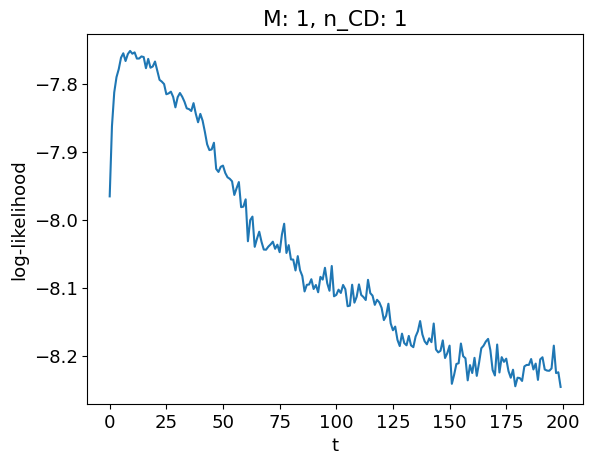

.............................................................................................
..................................................................................
M: 1, n_CD: 2
=================k==================================


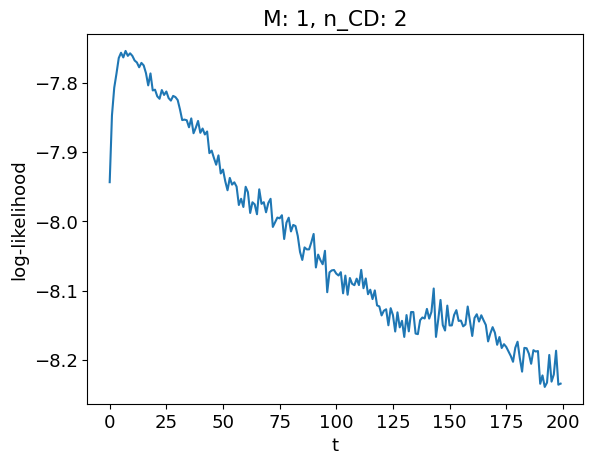

.............................................................................................
..................................................................................
M: 1, n_CD: 3
=================k==================================


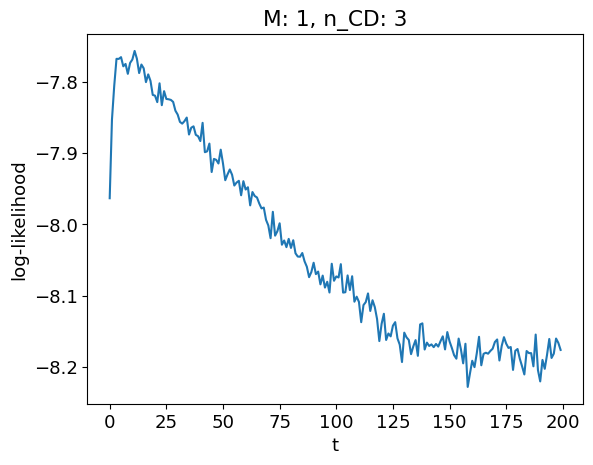

.............................................................................................
..................................................................................
M: 1, n_CD: 4
=================k==================================


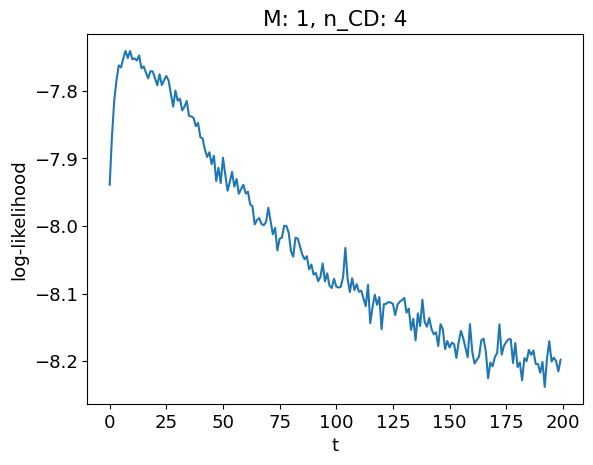

.............................................................................................
..................................................................................
M: 1, n_CD: 5
=================k==================================


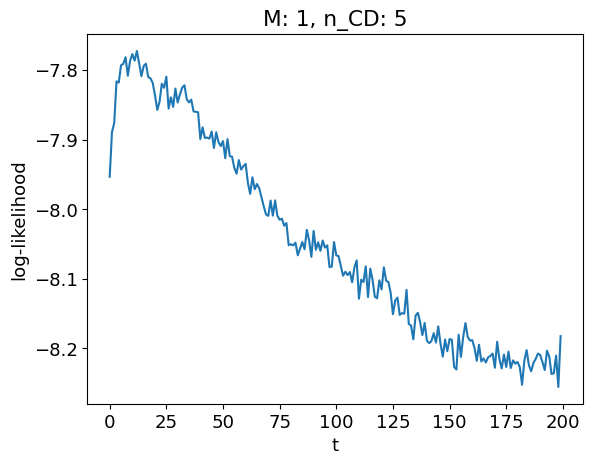

w= [[-0.53384471 -0.54502785]
 [ 0.25950245 -0.14100747]
 [-0.11785757  0.20277996]
 [-0.79559282 -0.49154926]
 [ 0.19315289  0.43351665]
 [-0.09488378 -0.46106842]
 [-0.08063979  0.21946959]
 [ 0.04097485  0.19153727]
 [-0.57866295  0.00243649]
 [-0.59736711 -0.10956393]]
a= [ 0.19938366 -0.39215132  0.76323232 -0.13919959 -1.05198874  0.35583065
  0.87585117  0.91698123  1.11234621  1.25267837]
b= [0. 0.]
.............................................................................................
..................................................................................
M: 2, n_CD: 1
=================k==================================


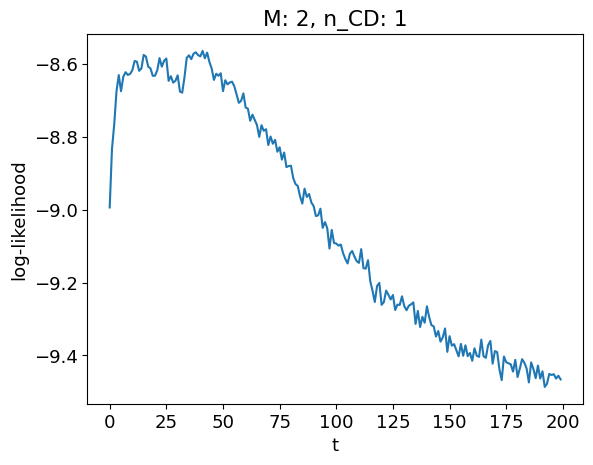

.............................................................................................
..................................................................................
M: 2, n_CD: 2
=================k==================================


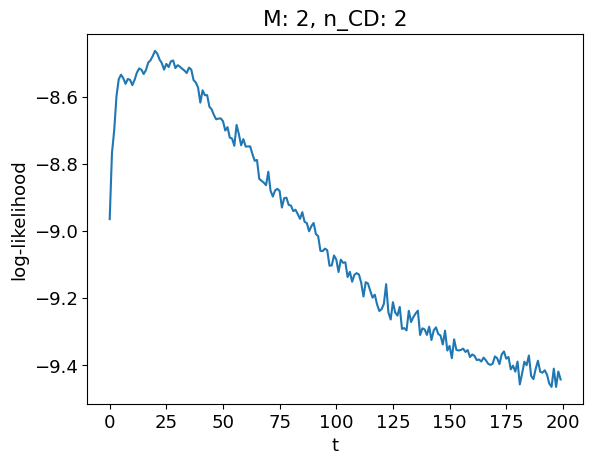

.............................................................................................
..................................................................................
M: 2, n_CD: 3
=================k==================================


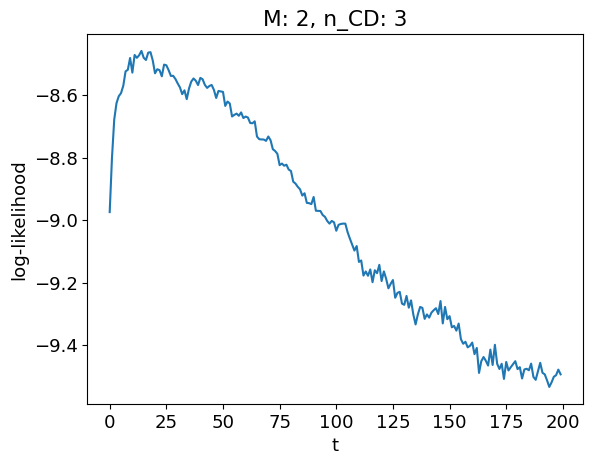

.............................................................................................
..................................................................................
M: 2, n_CD: 4
=================k==================================


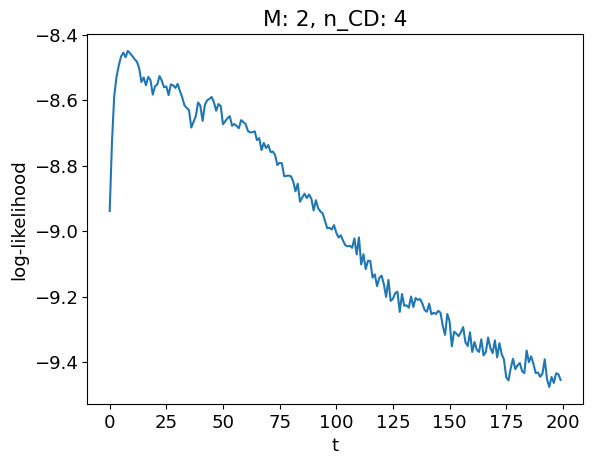

.............................................................................................
..................................................................................
M: 2, n_CD: 5
=================k==================================


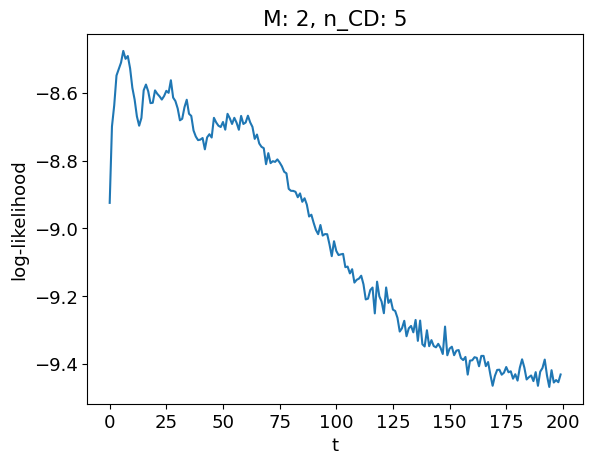

w= [[-0.0086541  -1.03352419  0.58699104]
 [ 0.26246883 -0.37199394 -1.15269862]
 [ 0.01293977  0.05741612 -0.1100354 ]
 [-0.05277345  0.32752074 -0.16928001]
 [-0.16982485 -0.64509362  0.29101417]
 [ 0.06878377  0.45602554  0.41746619]
 [ 0.11354952  0.24056567 -0.73264258]
 [-0.46892995  0.29568629 -0.55911806]
 [-0.33544861 -0.08410081 -0.73422092]
 [ 0.47360695  0.15703795 -0.3758095 ]]
a= [ 0.6332376  -0.25151973  0.42559419  0.20536267  0.16175906 -1.94771376
  0.86285371 -0.48678098 -0.13912258 -0.48537595]
b= [0. 0. 0.]
.............................................................................................
..................................................................................
M: 3, n_CD: 1
=================k==================================


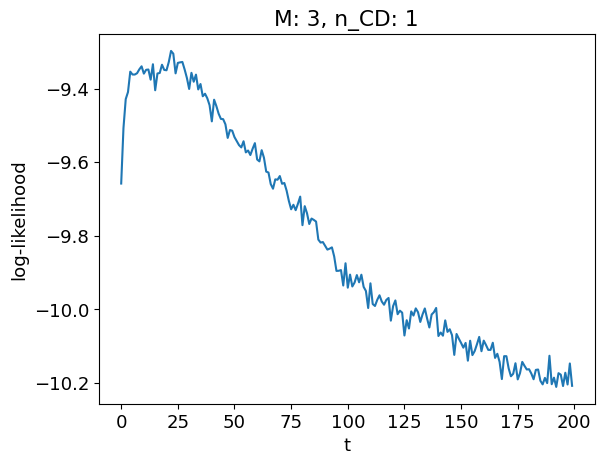

.............................................................................................
..................................................................................
M: 3, n_CD: 2
=================k==================================


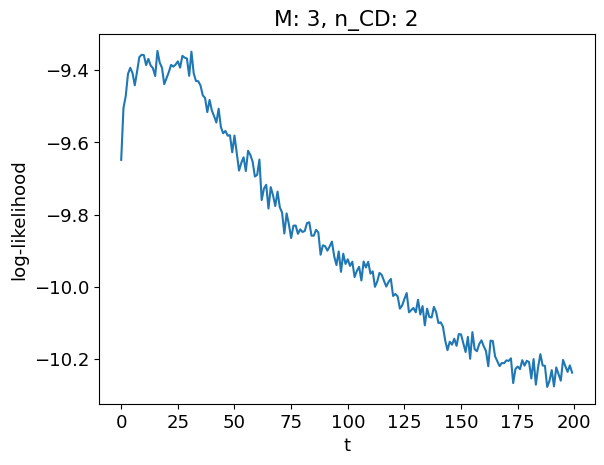

.............................................................................................
..................................................................................
M: 3, n_CD: 3
=================k==================================


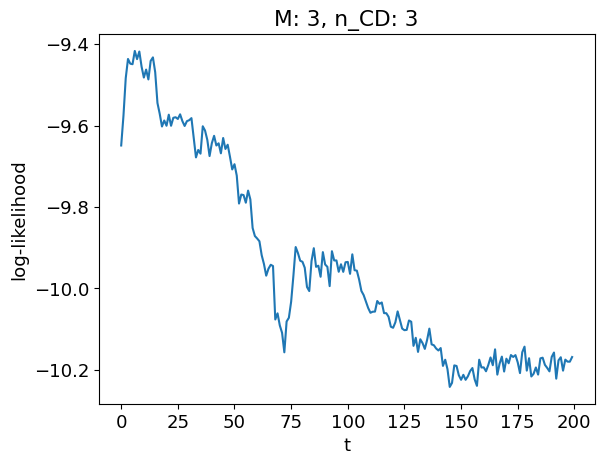

.............................................................................................
..................................................................................
M: 3, n_CD: 4
=================k==================================


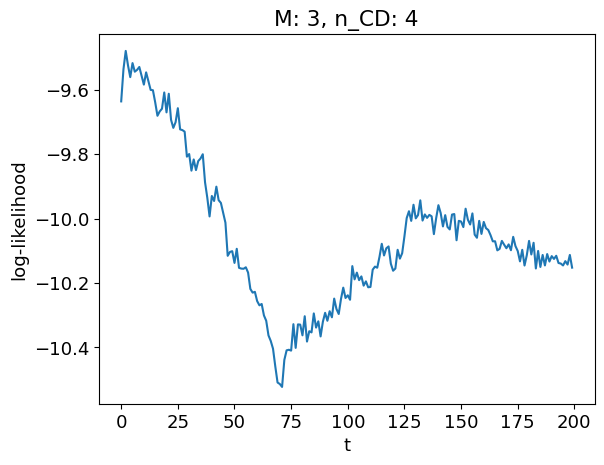

.............................................................................................
..................................................................................
M: 3, n_CD: 5
=================k==================================


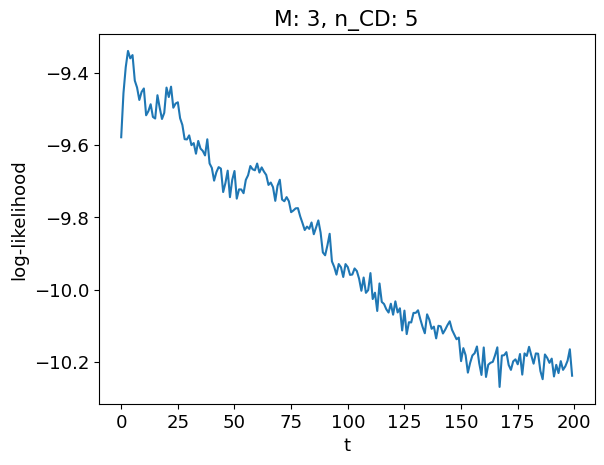

w= [[-0.00314629  0.57243115  1.00092845 -0.2447151 ]
 [ 0.56292471  0.14336755  0.02691931  0.01795697]
 [ 0.07791487 -0.59534965  0.15281095  0.06618465]
 [-1.18059621  0.94650432  0.79690045  0.66587239]
 [-0.40676155  0.331057   -0.0395075  -0.46435493]
 [ 0.27897361  0.38802092 -0.4137006   0.93824825]
 [ 0.00253651  0.14735585  0.1828823  -0.03057968]
 [ 0.79633822 -0.27085748 -0.17196968  0.41364543]
 [ 0.30253587  0.67734004  1.29626034  0.49287455]
 [ 0.21805349 -0.07905124  0.14534564 -0.24006896]]
a= [-0.41800585 -1.24149306  0.36511329 -0.51617463  0.42776042 -0.11262169
  0.32377397 -0.26660537 -0.48244765 -0.43199241]
b= [0. 0. 0. 0.]
.............................................................................................
..................................................................................
M: 4, n_CD: 1
=================k==================================


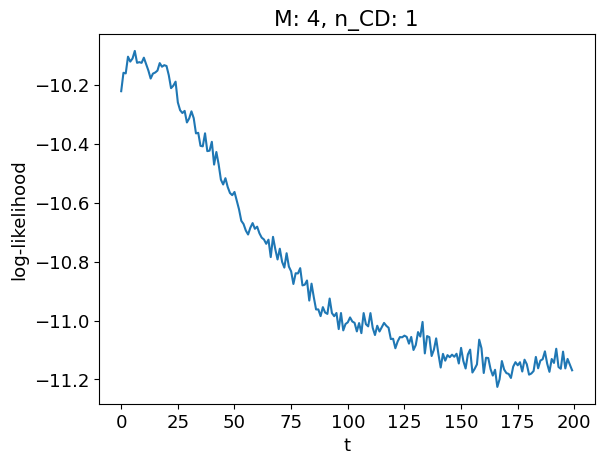

.............................................................................................
..................................................................................
M: 4, n_CD: 2
=================k==================================


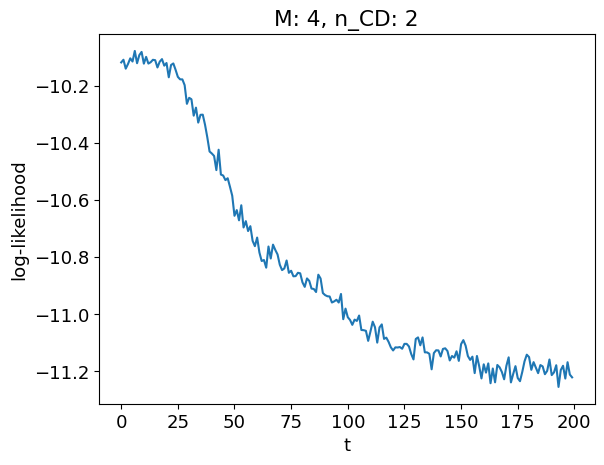

.............................................................................................
..................................................................................
M: 4, n_CD: 3
=================k==================================


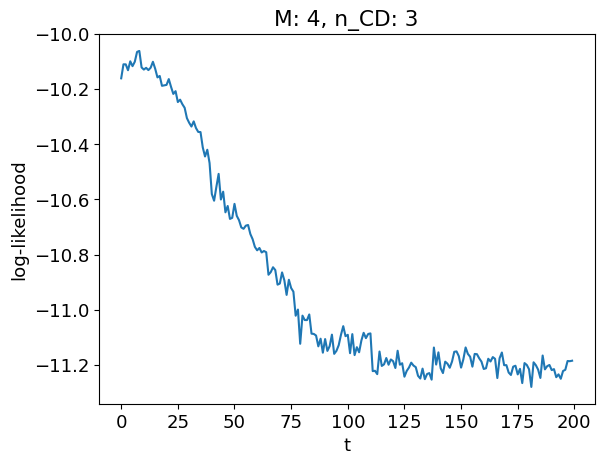

.............................................................................................
..................................................................................
M: 4, n_CD: 4
=================k==================================


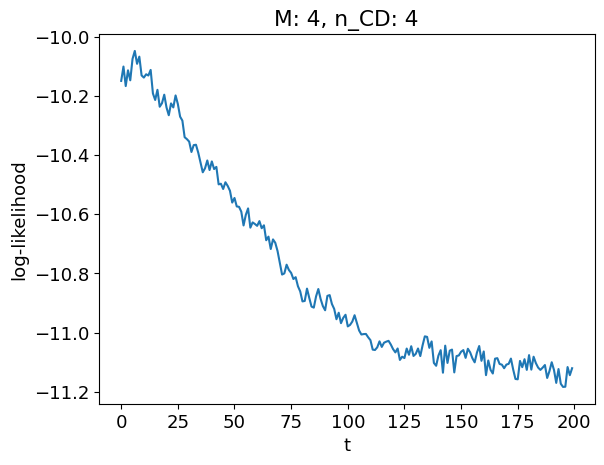

.............................................................................................
..................................................................................
M: 4, n_CD: 5
=================k==================================


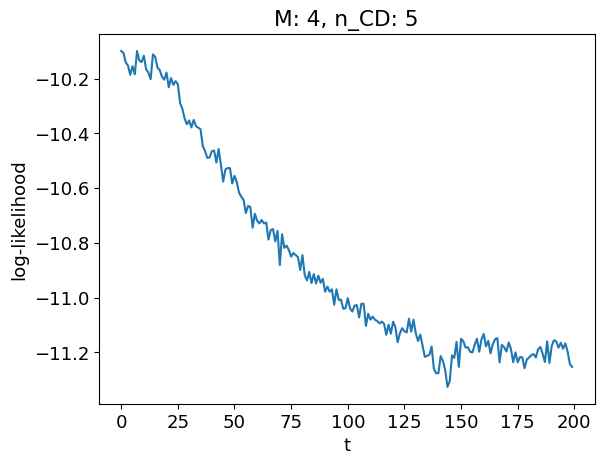

w= [[ 0.00412619  0.98468852 -0.05855859  0.20018577  0.2072159 ]
 [-0.16011606  0.48843804  0.09710443 -0.02766567 -0.43758379]
 [ 0.21621084  0.13967028  0.243641    0.29637545 -1.03155813]
 [-0.02520803 -0.39190598 -0.0731314  -0.42252168  0.08177591]
 [-0.5773572   0.54077439 -0.47875066  0.75676208 -0.66367386]
 [-1.59860408 -0.02833387  0.667462   -0.64796978  1.24179344]
 [ 0.20136324 -0.30891639  0.33795942  0.47175566  0.37705175]
 [ 0.08553695  0.07134677  0.46000556 -0.19283535 -0.18354082]
 [-0.28710396  0.34980532 -0.05698341  0.08147789 -0.86303286]
 [-0.17833462 -0.63040946  1.44841132  0.64188079 -1.09059346]]
a= [-0.48820909  0.28535491 -0.44608139 -0.29517362 -0.04565729 -0.34740444
  0.75726547  0.79322825  0.60500999 -0.7727951 ]
b= [0. 0. 0. 0. 0.]
.............................................................................................
..................................................................................
M: 5, n_CD: 1
=================k===========

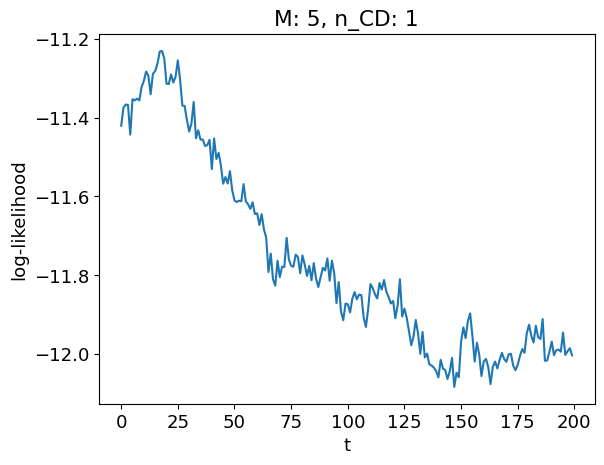

.............................................................................................
..................................................................................
M: 5, n_CD: 2
=================k==================================


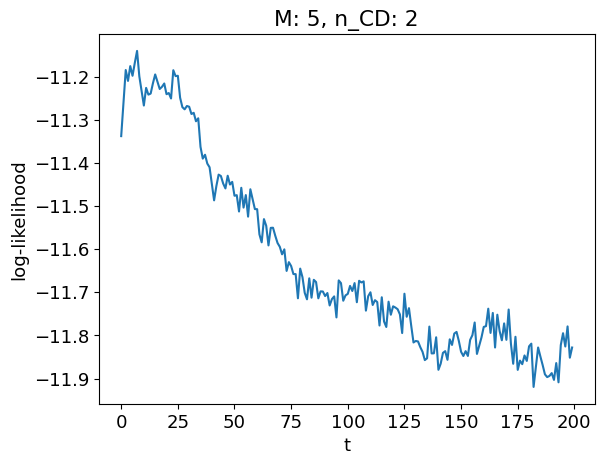

.............................................................................................
..................................................................................
M: 5, n_CD: 3
=================k==================================


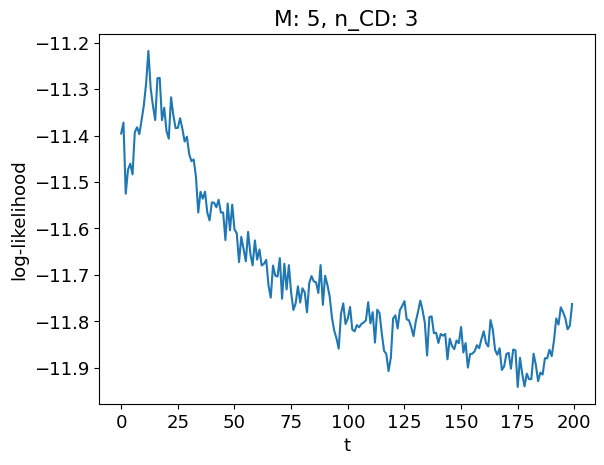

.............................................................................................
..................................................................................
M: 5, n_CD: 4
=================k==================================


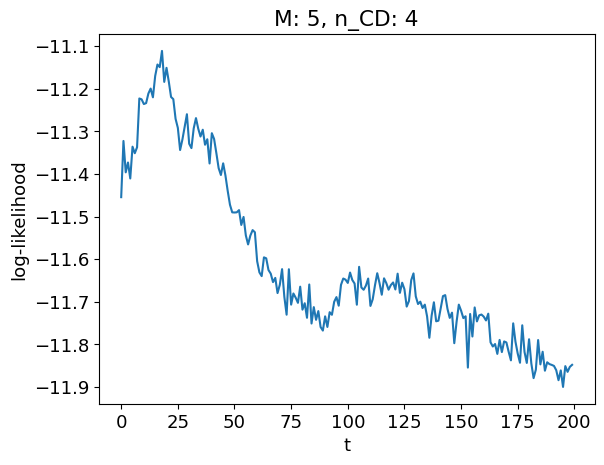

.............................................................................................
..................................................................................
M: 5, n_CD: 5
=================k==================================


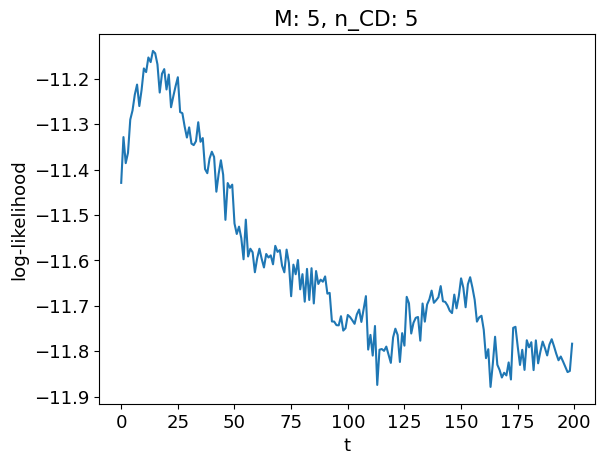

w= [[ 0.21878803 -0.63114398  0.04723785  0.62453104 -0.44603875 -0.22425606]
 [-0.47167987 -0.12688834  0.02831949  0.52108854  0.83877873  0.64089493]
 [ 0.51194864  0.32175338  0.31855142  0.55504901  0.19321896  0.34838687]
 [-0.13908679  0.58441446 -0.12058987 -0.24327627 -0.42962332  0.60458083]
 [ 0.24240067  0.04852466 -0.18043917  0.8060481   0.36736281  0.08186126]
 [-0.38453538 -0.25446627 -1.08113146  0.37744877  1.32294886 -0.43543451]
 [-0.10723007  0.79342223  0.72479143 -0.80342886 -0.86110734 -0.67777222]
 [-0.51760218 -0.08233967  0.49298434 -0.79591216  1.18728383 -0.58239619]
 [-0.07075024 -0.04837954 -0.768363   -0.13908106  0.70109416  0.96581003]
 [ 0.27768717  0.15553148 -0.20222202  0.60611774  0.15602711 -0.08555377]]
a= [-0.90949943  0.13070714  0.63008123 -0.2268147  -0.1912415   0.33893274
  0.58724227  1.02318636 -0.3128773  -0.49948799]
b= [0. 0. 0. 0. 0. 0.]
.............................................................................................
...

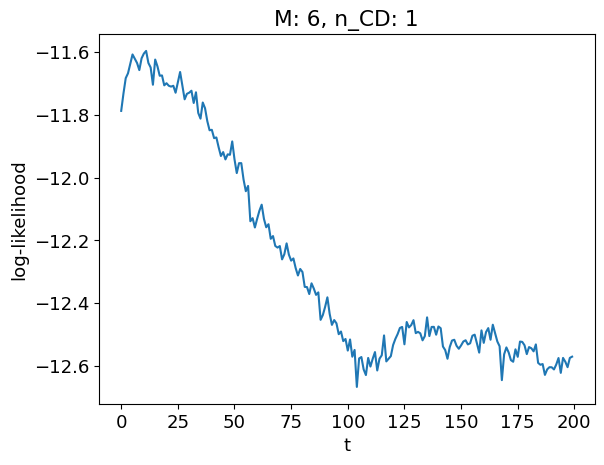

.............................................................................................
..................................................................................
M: 6, n_CD: 2
=================k==================================


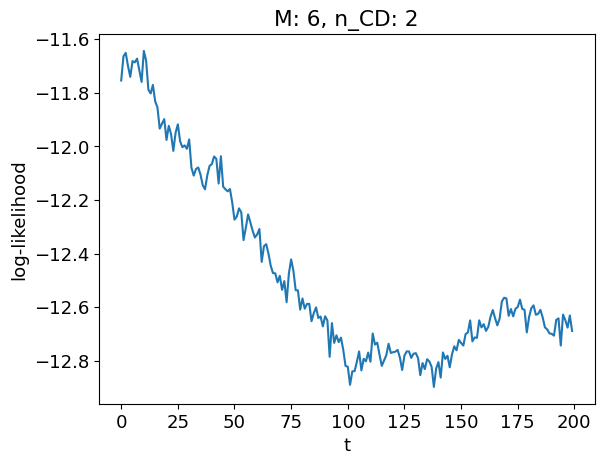

.............................................................................................
..................................................................................
M: 6, n_CD: 3
=================k==================================


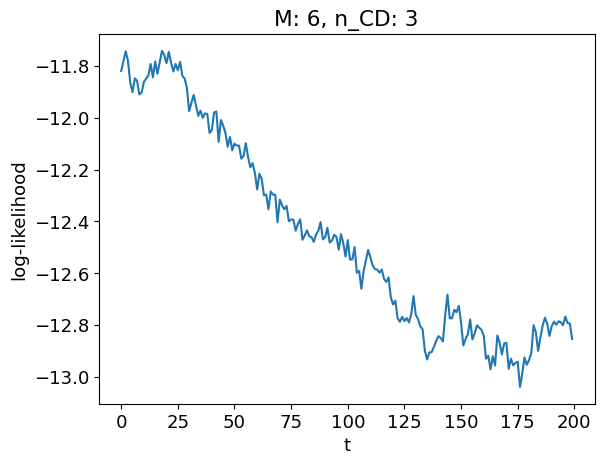

.............................................................................................
..................................................................................
M: 6, n_CD: 4
=================k==================================


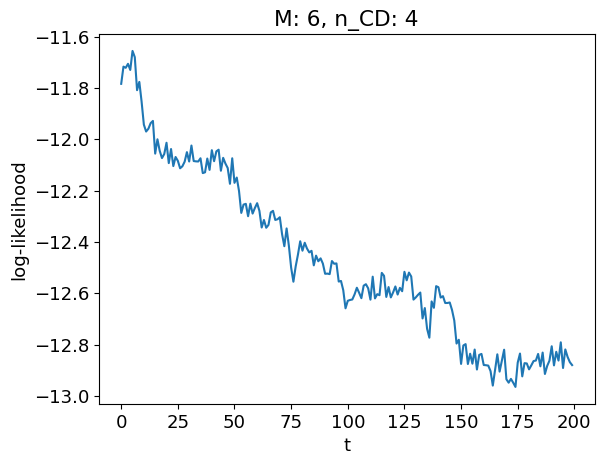

.............................................................................................
..................................................................................
M: 6, n_CD: 5
=================k==================================


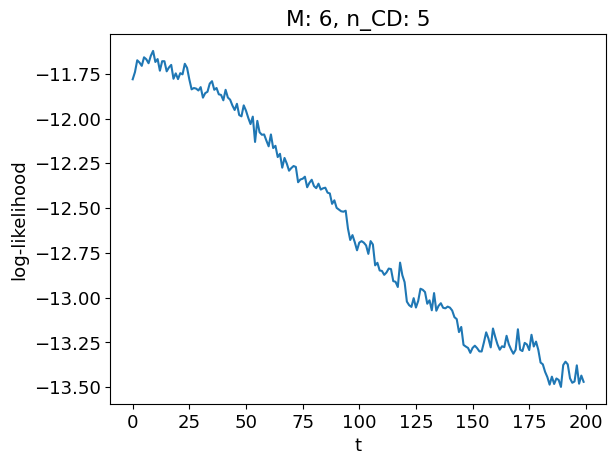

In [60]:
result_log={} #dictionary to store the likelihoods relative to different parameters combinations
for M in range(1,7):
    #M: number of hidden units
    # range of each initial weight
    sigma = sqrt(4. / float(L + M))
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(L,M)
    a = sigma * np.random.randn(L)
    b = np.zeros(M)
    print("w=",w);print("a=",a);print("b=",b)
    w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)
    for n_CD in range(1,6):
        print('.............................................................................................\n..................................................................................')
        print(f'M: {M}, n_CD: {n_CD}')
        RBM_trainer(w0,a0,b0,n_CD=n_CD, epochs=10, show_model=False, verbose=False, result_log=result_log)

In [ ]:
#this snippet is just to plot preliminarly the log-likelihood global trend among different hyperparameter choices, in particular to verify the quickly raising and then steadily decreasing behaviour with `t`.
#Legend labels denote `M` and `n_CD` values respectively
for el in result_log:
    plt.plot(result_log[el], label=str(el))
    print(el)
    plt.legend(prop={'size':5})
plt.xlabel('t')
plt.ylabel('log-likelihood')
plt.show()

Below we plot a heatmap of the maximum (along `t`) log-likelihood with respect to the `M` and `n_CD` considered.

[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6]
[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]
[-7.75091474052112, -7.75368272332851, -7.756289718112665, -7.741301277761541, -7.772159066217891, -8.564544862983128, -8.463042822360899, -8.45863212310021, -8.449414822527142, -8.47705369854691, -9.29765737902982, -9.346697984753936, -9.416481228281752, -9.47869856355081, -9.338998035933866, -10.08350853116241, -10.077732317997025, -10.06076258869905, -10.047872373531371, -10.09847745745979, -11.230811881308915, -11.140216669720552, -11.217871470455865, -11.111287435512082, -11.138571935033635, -11.595885458369667, -11.643650953602123, -11.74302423839938, -11.656134508036137, -11.622529804668591]
[[ -7.75091474  -7.75368272  -7.75628972  -7.74130128  -7.77215907]
 [ -8.56454486  -8.46304282  -8.45863212  -8.44941482  -8.4770537 ]
 [ -9.29765738  -9.34669798  -9.41648123  -9.47869856  -9.33899804]
 [-10.08

/tmp/ipykernel_253524/2981281745.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivoted=df.pivot('x', 'y', 'z')


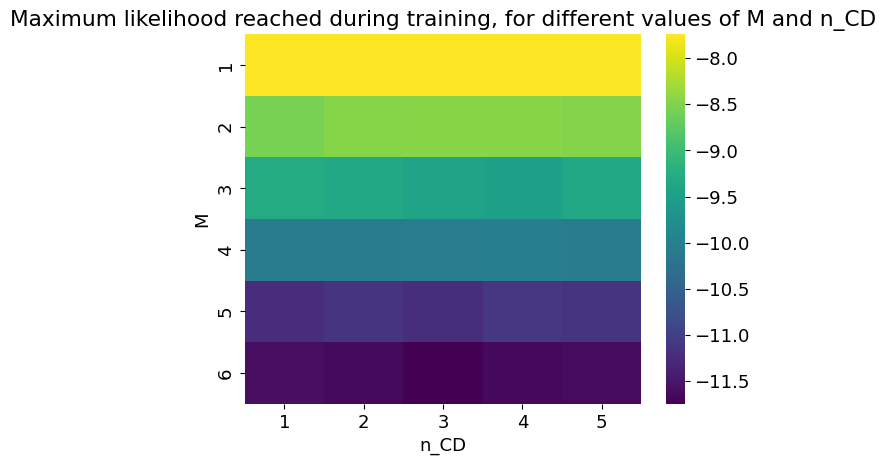

In [98]:
import seaborn as sns


x = [key[0] for key in result_log.keys()]
y = [key[1] for key in result_log.keys()]
z = [max(loglike) for loglike in result_log.values()]
print(x)
print(y)
print(z)
array=np.zeros((len(set(x)), len(set(y))))
for i in range(len(z)):
    array[x[i]-1,y[i]-1]=z[i]
print(array)

# Create a DataFrame for Seaborn
data = {'x': x, 'y': y, 'z': z}
df = pd.DataFrame(data)
pivoted=df.pivot('x', 'y', 'z') 
# Create a 2D KDE plot
sns.heatmap(data=pivoted, cmap='viridis')
plt.xlabel('n_CD')
plt.ylabel('M')
plt.title('Maximum likelihood reached during training, for different values of M and n_CD')
plt.show()


We sort and select the hyperparameters combinations w.r.t. maximum likelihood reached during training.

In [91]:
print(list(result_log.items()))
sorted_loglikes=sorted(list(result_log.items()), key=lambda x: max(x[1]), reverse=True)
print([entry[0] for entry in sorted_loglikes[:5]])

[((1, 1), [-7.96508543640057, -7.861689664997649, -7.812059075853211, -7.7895313643914275, -7.777624730696766, -7.760836570692996, -7.754380457543278, -7.765765902700639, -7.7555764349207665, -7.75091474052112, -7.75502133183217, -7.75304977094659, -7.762151199471388, -7.7621002535876595, -7.759013854175583, -7.759912004953245, -7.776325673150186, -7.762631723208668, -7.775663008930133, -7.7738416828405414, -7.7665497703804816, -7.780036108643218, -7.793486916383452, -7.796136032698416, -7.799713254702309, -7.8147062755411785, -7.813458533545221, -7.810885674663482, -7.81860863781158, -7.833992130956826, -7.818977618019697, -7.812882342078876, -7.818345779422454, -7.825723826329935, -7.835467041454857, -7.836616212027168, -7.83933944775871, -7.827789592521669, -7.843502710719456, -7.855969777658321, -7.843636607365623, -7.853562683719029, -7.8700162030820175, -7.88839184511998, -7.896936021705176, -7.895974727464977, -7.8861277872067195, -7.924645921172496, -7.929122795336255, -7.92155

Below we plot the graph of the log-likelihood as a function of `t` (see above) for our best hyperparameters.

Text(0.5, 1.0, 'M=1, n_CD=4')

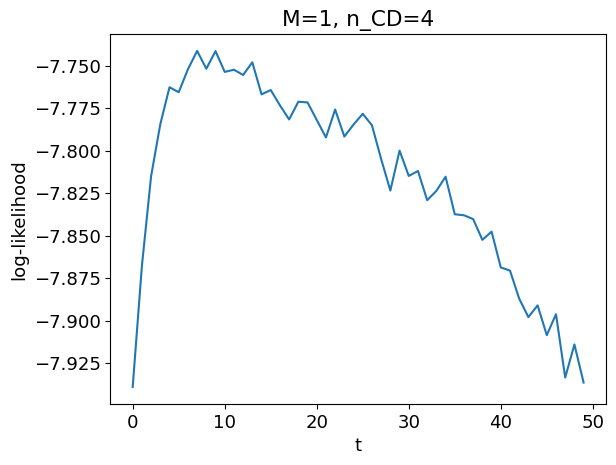

In [92]:
#plt.plot(result_log['M1_nCD4'])
plt.plot(result_log[(1,4)][:50])
plt.xlabel('t')
plt.ylabel('log-likelihood')
plt.title('M=1, n_CD=4')

For M=3, we plot L as a function of “t”, comparing the two contrastive divergence cases (n=1 and
n=5).

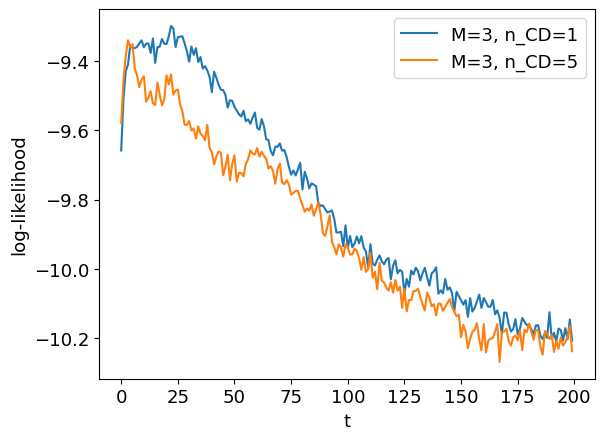

In [93]:
#plt.plot(result_log['M1_nCD4'])
plt.plot(result_log[(3,1)][:200], label='M=3, n_CD=1')
plt.plot(result_log[(3,5)][:200], label='M=3, n_CD=5')
plt.xlabel('t')
plt.ylabel('log-likelihood')
plt.legend()

We do not observe much difference in this range of `t`, except for a slightly lower likelihood of the `n_CD=5` model.

Then, for n=1, plot L as a function of “t”, comparing two cases with different M (M=1 and M=6).

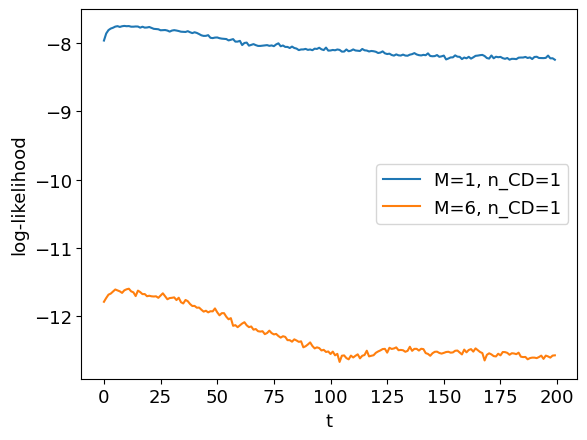

In [94]:
#plt.plot(result_log['M1_nCD4'])
plt.plot(result_log[(1,1)][:200], label='M=1, n_CD=1')
plt.plot(result_log[(6,1)][:200], label='M=6, n_CD=1')
plt.xlabel('t')
plt.ylabel('log-likelihood')
plt.legend()

The likelihood of the `M=1` model is significantly better compared to the `M=6` one.

In [95]:
print('w0=',w0);print('a0=',a0);print('b0=',b0)
print('w=',w);print('a=',a);print('b=',b)

w0= [[-0.12344336]
 [ 0.2888137 ]
 [-0.31323333]
 [-0.33511798]
 [ 1.18541029]
 [ 0.84025533]
 [ 0.05602556]
 [ 0.16989932]
 [ 0.46373806]
 [ 0.75162843]]
a0= [ 0.60735803 -0.78165074  0.16582619  0.13803966  0.81583955  0.534537
 -1.20703271 -0.22422949  1.00646013 -0.2644675 ]
b0= [0.]
w= [[-0.12344336]
 [ 0.2888137 ]
 [-0.31323333]
 [-0.33511798]
 [ 1.18541029]
 [ 0.84025533]
 [ 0.05602556]
 [ 0.16989932]
 [ 0.46373806]
 [ 0.75162843]]
a= [ 0.60735803 -0.78165074  0.16582619  0.13803966  0.81583955  0.534537
 -1.20703271 -0.22422949  1.00646013 -0.2644675 ]
b= [0.]


We train `w`, `a` and `b` with the highest log-likelihood hyperparameters choice selected, and meanwhile also show the log-likelihood values for a greater number of epochs (50) as a further check.

w= [[-0.12344336]
 [ 0.2888137 ]
 [-0.31323333]
 [-0.33511798]
 [ 1.18541029]
 [ 0.84025533]
 [ 0.05602556]
 [ 0.16989932]
 [ 0.46373806]
 [ 0.75162843]]
a= [ 0.60735803 -0.78165074  0.16582619  0.13803966  0.81583955  0.534537
 -1.20703271 -0.22422949  1.00646013 -0.2644675 ]
b= [0.]
.............................................................................................
..................................................................................
M: 1, n_CD: 4
=================k==================================


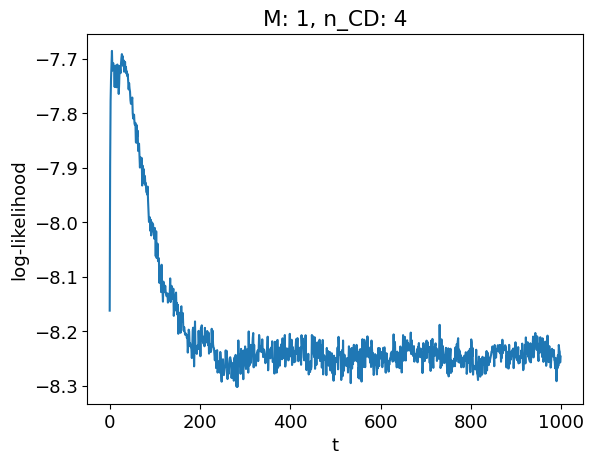

In [96]:
# best likelihood with M=1 and n_CD=4
M=1
n_CD=4
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)
print('.............................................................................................\n..................................................................................')
print(f'M: {M}, n_CD: {n_CD}')
RBM_trainer(w0,a0,b0,n_CD=n_CD, epochs=50, show_model=False, verbose=False)

## Test: noise reduction

We now increase the `GAP` variable by means of a large `ampl` factor. This turns the sigmoid function associated to the activation of the node approximate a Heavyside function. Thus, the fantasy sample generation returns only the most probable samples, that should correspond to the denoised dataset.

In [97]:
from IPython.display import display_html 
import pandas as pd

ampl=40.

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = activate(v0[k],w,b,ampl*GAP)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = activate(h,w.T,a,ampl*GAP)
    
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(mini)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  

N1=100
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Denoised').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,1,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,1,0,1,0,0
4,1,1,1,0,1,1,1,1,0,0
5,0,1,0,0,1,1,1,0,0,0
6,1,0,1,0,0,0,1,1,1,1
7,1,0,1,1,0,1,1,0,0,0
8,1,0,1,0,0,0,0,1,1,1
9,1,1,0,0,1,1,0,0,0,0


By looking at the result, we suggest that the structure of the dataset could be a repeated sampling of the following sequence: '1000110011'.